In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg2
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Properties

## Get Data

In [96]:
conn = pg2.connect(dbname='impulsify', user='postgres', host='localhost', port='5435')
sql = '''select p.property_code
    , p.id property_id
    , p.name property_name
    , p.address
    , p.city
    , p.state
    , p.zip
    , p.sales_tax_rate
    , p.alcohol_tax_rate
    , p.tobacco_tax_rate
    , p.management_company_id
    , p.flag_id
    , f.name flag_name
    , f.brand_id
    , b.name brand_name
    , p.kind
    , p.guest_profile
    , p.currency_id
    , p.location_type
    , p.rooms

from properties p

LEFT JOIN brands AS b
    ON p.brand_id = b.id
             
LEFT JOIN flags AS f
    ON p.flag_id = f.id
    
;'''
props = sqlio.read_sql_query(sql, conn)
conn = None

In [97]:
props.head()

,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms
0,MOBDO,7530,Hilton Garden Inn Downtown Mobile,15 North Conception Street,Mobile,AL,36602,0.0,0.0,0.0,25598,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,93
1,DFWEU,7528,Tru by Hilton Euless DFW West,2570 State Highway 121,Euless,TX,76039,0.0,0.0,0.0,10526,147,Tru by Hilton,1,Hilton,Select Service,Equal Combination,1,Interstate,79
2,CHIWX,7534,Hampton Inn Chicago West Loop,116 N Jefferson,Chicago,IL,60661,0.0,0.0,0.0,3631,31,Hampton Inn,1,Hilton,Select Service,Equal Combination,1,Urban,210
3,RAPGI,7216,Hilton Garden Inn Rapid City,815 E. Mall Drive,Rapid City,SD,57701,6.5,7.5,0.0,3231,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,120
4,SATAA,7478,Hilton Garden Inn San Antonio Airport South,8505 Broadway,San Antonio,TX,78217,0.0,0.0,0.0,611,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Airport,126


In [98]:
props[props.zip.str.isnumeric()].zip.unique()

array(['36602', '76039', '60661', '57701', '78217', '80202', '75063',
       '97702', '92562', '78230', '71753', '30345', '79706', '87301',
       '43215', '74133', '92395', '78202', '53226', '98901', '19406',
       '19073', '23434', '30501', '28027', '98801', '37090', '78374',
       '83702', '92106', '60062', '80246', '80249', '98121', '28312',
       '03801', '72301', '59102', '73134', '74361', '30346', '79938',
       '80916', '75013', '82601', '64105', '95821', '94502', '79765',
       '95035', '85374', '30121', '29625', '77494', '46514', '55811',
       '80228', '54601', '84043', '85258', '78753', '56001', '27215',
       '94533', '92630', '85323', '33619', '32080', '11794', '37701',
       '45424', '28012', '15061', '94607', '71111', '78701', '02021',
       '92408', '32822', '86001', '32836', '80011', '17602', '76054',
       '80033', '57732', '73099', '93001', '97301', '75220', '24382',
       '32903', '33905', '79424', '32055', '28117', '29483', '29673',
       '20603', '297

## Feature Engineering

In [99]:
props['currency'] = np.where(props.currency_id == 1, 'USD', 'CAD')
props.zip = np.where(props.zip.str.isnumeric(),props.zip.astype(str).str[0],'can')

mgmt = pd.DataFrame(props['management_company_id'].value_counts()).reset_index()
mgmt.rename(columns={'index':'management_company_id',
                     'management_company_id':'props_under_mgmt'}, inplace=True)
props = props.merge(mgmt, on=('management_company_id'))

In [100]:
props.head()

,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt
0,MOBDO,7530,Hilton Garden Inn Downtown Mobile,15 North Conception Street,Mobile,AL,3,0.00,0.0,0.0,25598,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,93,USD,1
1,DFWEU,7528,Tru by Hilton Euless DFW West,2570 State Highway 121,Euless,TX,7,0.00,0.0,0.0,10526,147,Tru by Hilton,1,Hilton,Select Service,Equal Combination,1,Interstate,79,USD,3
2,DFWEL,7529,Home2 Suites by Hilton Euless DFW West,2570 State Highway 121,Euless,TX,7,0.00,0.0,0.0,10526,51,Home2,1,Hilton,Extended Stay,Equal Combination,1,Interstate,94,USD,3
3,DALDR,6691,Hampton Inn & Suites Dallas Richardson,2250 N Glenville Dr.,Richardson,TX,7,8.25,0.0,0.0,10526,21,Hampton Inn and Suites,1,Hilton,Select Service,Business Travel,1,Suburban,101,USD,3
4,CHIWX,7534,Hampton Inn Chicago West Loop,116 N Jefferson,Chicago,IL,6,0.00,0.0,0.0,3631,31,Hampton Inn,1,Hilton,Select Service,Equal Combination,1,Urban,210,USD,2


## EDA

''

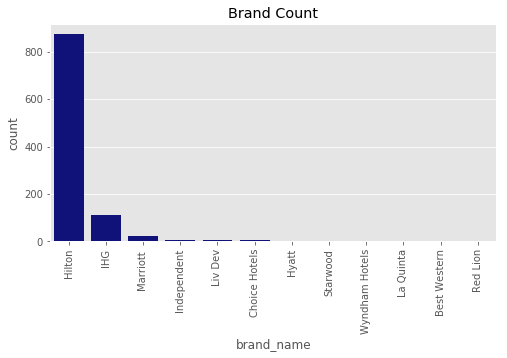

In [101]:
fig, ax = plt.subplots(figsize = (8,4))

sns.countplot('brand_name', data = props, ax = ax, color = 'darkblue',
              order = props['brand_name'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Brand Count')
;

''

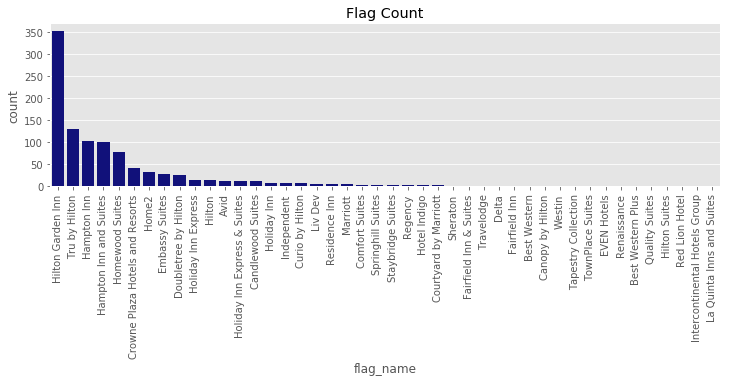

In [102]:
fig, ax = plt.subplots(figsize = (12,3))

sns.countplot('flag_name', data = props, ax = ax, color = 'darkblue',
              order = props['flag_name'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Flag Count')
;

''

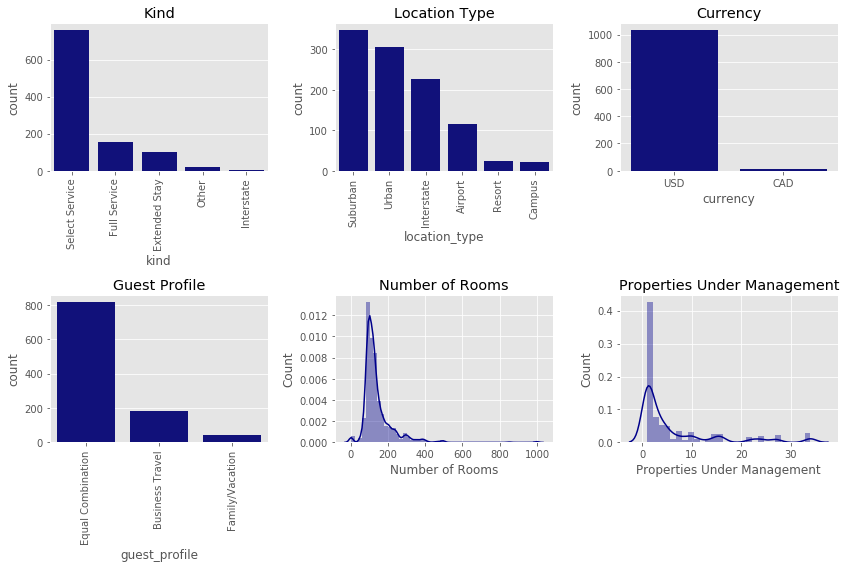

In [103]:
fig, ax = plt.subplots(2,3, figsize = (12,8))

sns.countplot('kind', data = props, ax = ax[0,0], color = 'darkblue',
              order = props['kind'].value_counts().index)
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=90)
ax[0,0].set_title('Kind')

sns.countplot('location_type', data = props, ax = ax[0,1], color = 'darkblue',
              order = props['location_type'].value_counts().index)
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=90)
ax[0,1].set_title('Location Type')

sns.countplot('currency', data = props, ax = ax[0,2], color = 'darkblue',
              order = props['currency'].value_counts().index)
ax[0,2].set_title('Currency')

sns.countplot('guest_profile', data = props, ax = ax[1,0], color = 'darkblue',
              order = props['guest_profile'].value_counts().index)
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=90)
ax[1,0].set_title('Guest Profile')

sns.distplot(props.rooms, ax = ax[1,1], color = 'darkblue')
ax[1,1].set_title('Number of Rooms')
ax[1,1].set_xlabel('Number of Rooms')
ax[1,1].set_ylabel('Count')

sns.distplot(props.props_under_mgmt, ax = ax[1,2], color = 'darkblue')
ax[1,2].set_title('Properties Under Management')
ax[1,2].set_xlabel('Properties Under Management')
ax[1,2].set_ylabel('Count')


fig.tight_layout()
;

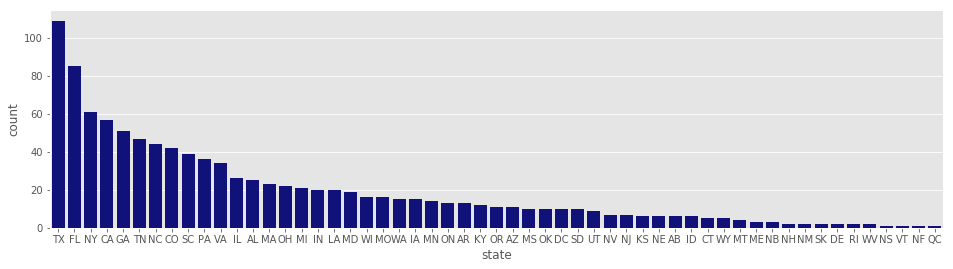

In [104]:
fig, ax = plt.subplots(figsize = (16,4))
sns.countplot('state', data = props, ax = ax, color = 'darkblue',
              order = props['state'].value_counts().index);

## One-Hot Encoding

In [105]:
props_mod = props.copy()
index_col = ['property_id']
numeric_cols = ['props_under_mgmt','rooms',
                #'alcohol_tax_rate', 'sales_tax_rate', 'tobacco_tax_rate'
               ]
dummy_cols = ['kind','guest_profile','location_type',
              'currency','flag_name','zip']
drop_cols = list(set(props.columns) - set(index_col) - set(numeric_cols))
set(drop_cols)

{'address',
 'alcohol_tax_rate',
 'brand_id',
 'brand_name',
 'city',
 'currency',
 'currency_id',
 'flag_id',
 'flag_name',
 'guest_profile',
 'kind',
 'location_type',
 'management_company_id',
 'property_code',
 'property_name',
 'sales_tax_rate',
 'state',
 'tobacco_tax_rate',
 'zip'}

* brand_name and flag_name have overlap in their definitions. Should drop one of them.
* Likewise, zip and state have overlap. Should not use both.

In [106]:
props_mod = props_mod.merge(pd.get_dummies(data = props_mod,columns = dummy_cols,drop_first=True))

In [107]:
props_mod = props_mod.drop(drop_cols , axis = 1)
props_mod.index = props_mod.property_id
props_mod.drop(index_col, axis = 1 , inplace = True)

In [108]:
props_mod.head()

,rooms,props_under_mgmt,kind_Full Service,kind_Interstate,kind_Other,kind_Select Service,guest_profile_Equal Combination,guest_profile_Family/Vacation,location_type_Campus,location_type_Interstate,location_type_Resort,location_type_Suburban,location_type_Urban,currency_USD,flag_name_Best Western,flag_name_Best Western Plus,flag_name_Candlewood Suites,flag_name_Canopy by Hilton,flag_name_Comfort Suites,flag_name_Courtyard by Marriott,flag_name_Crowne Plaza Hotels and Resorts,flag_name_Curio by Hilton,flag_name_Delta,flag_name_Doubletree by Hilton,flag_name_EVEN Hotels,flag_name_Embassy Suites,flag_name_Fairfield Inn,flag_name_Fairfield Inn & Suites,flag_name_Hampton Inn,flag_name_Hampton Inn and Suites,flag_name_Hilton,flag_name_Hilton Garden Inn,flag_name_Hilton Suites,flag_name_Holiday Inn,flag_name_Holiday Inn Express,flag_name_Holiday Inn Express & Suites,flag_name_Home2,flag_name_Homewood Suites,flag_name_Hotel Indigo,flag_name_Independent,flag_name_Intercontinental Hotels Group,flag_name_La Quinta Inns and Suites,flag_name_Liv Dev,flag_name_Marriott,flag_name_Quality Suites,flag_name_Red Lion Hotel,flag_name_Regency,flag_name_Renaissance,flag_name_Residence Inn,flag_name_Sheraton,flag_name_Springhill Suites,flag_name_Staybridge Suites,flag_name_Tapestry Collection,flag_name_TownPlace Suites,flag_name_Travelodge,flag_name_Tru by Hilton,flag_name_Westin,zip_1,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9,zip_can
property_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7530,93,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7528,79,3,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
7529,94,3,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6691,101,3,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7534,210,2,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# PCA

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
props_mod_ss = scaler.fit_transform(props_mod)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_fit = pca.fit(props_mod_ss)
props_mod_pca = pca.fit_transform(props_mod_ss)

### Loadings

In [110]:
pca_loadings = pd.DataFrame(pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_))
pca_loadings.columns = ['pc1','pc2']
pca_loadings['feature'] = props_mod.columns

''

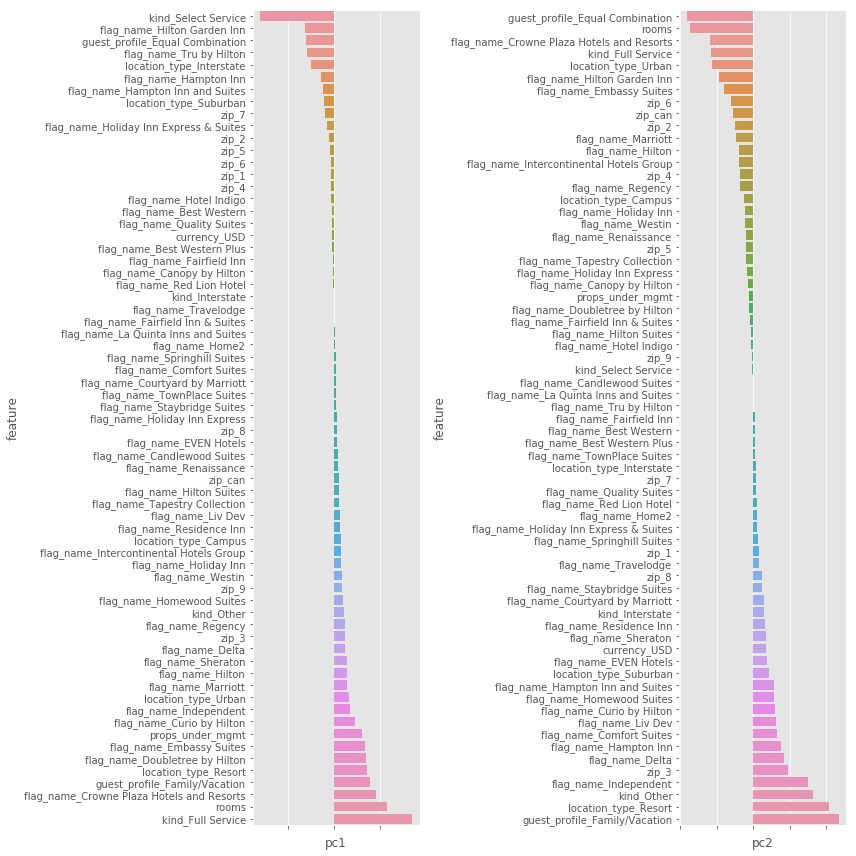

In [111]:
fig, ax = plt.subplots(1,2, figsize=(12,12))

sns.barplot(y = 'feature', x = 'pc1', data = pca_loadings.sort_values('pc1'), ax = ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.barplot(y = 'feature', x = 'pc2', data = pca_loadings.sort_values('pc2'), ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.tight_layout()
;

In [112]:
props_mod_pca = pd.DataFrame(props_mod_pca)
props_mod_pca.columns = ['pc1','pc2']
props_mod_pca.head()

,pc1,pc2
0,-0.849534,-0.342654
1,-1.853690,0.127906
2,-0.264996,0.202397
3,-0.859171,1.269357
4,-0.528747,-0.861265


In [113]:
props_mod.shape

(1040, 67)

In [114]:
#props_mod = props_mod.reset_index()

In [115]:
props = pd.concat([props, props_mod_pca], axis=1)

In [116]:
props.head()

,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2
0,MOBDO,7530,Hilton Garden Inn Downtown Mobile,15 North Conception Street,Mobile,AL,3,0.00,0.0,0.0,25598,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,93,USD,1,-0.849534,-0.342654
1,DFWEU,7528,Tru by Hilton Euless DFW West,2570 State Highway 121,Euless,TX,7,0.00,0.0,0.0,10526,147,Tru by Hilton,1,Hilton,Select Service,Equal Combination,1,Interstate,79,USD,3,-1.853690,0.127906
2,DFWEL,7529,Home2 Suites by Hilton Euless DFW West,2570 State Highway 121,Euless,TX,7,0.00,0.0,0.0,10526,51,Home2,1,Hilton,Extended Stay,Equal Combination,1,Interstate,94,USD,3,-0.264996,0.202397
3,DALDR,6691,Hampton Inn & Suites Dallas Richardson,2250 N Glenville Dr.,Richardson,TX,7,8.25,0.0,0.0,10526,21,Hampton Inn and Suites,1,Hilton,Select Service,Business Travel,1,Suburban,101,USD,3,-0.859171,1.269357
4,CHIWX,7534,Hampton Inn Chicago West Loop,116 N Jefferson,Chicago,IL,6,0.00,0.0,0.0,3631,31,Hampton Inn,1,Hilton,Select Service,Equal Combination,1,Urban,210,USD,2,-0.528747,-0.861265


In [117]:
def pca_plot(x, y, df, group=None, axs=None):
    if group:
        pal = sns.color_palette("Paired", df[group].unique().shape[0])
    else:
        pal = None
    sns.scatterplot(x, y, data = df, hue = group, palette = pal,
                    alpha = .9, ax = axs).set_title('Grouping: ' + str(group))

''

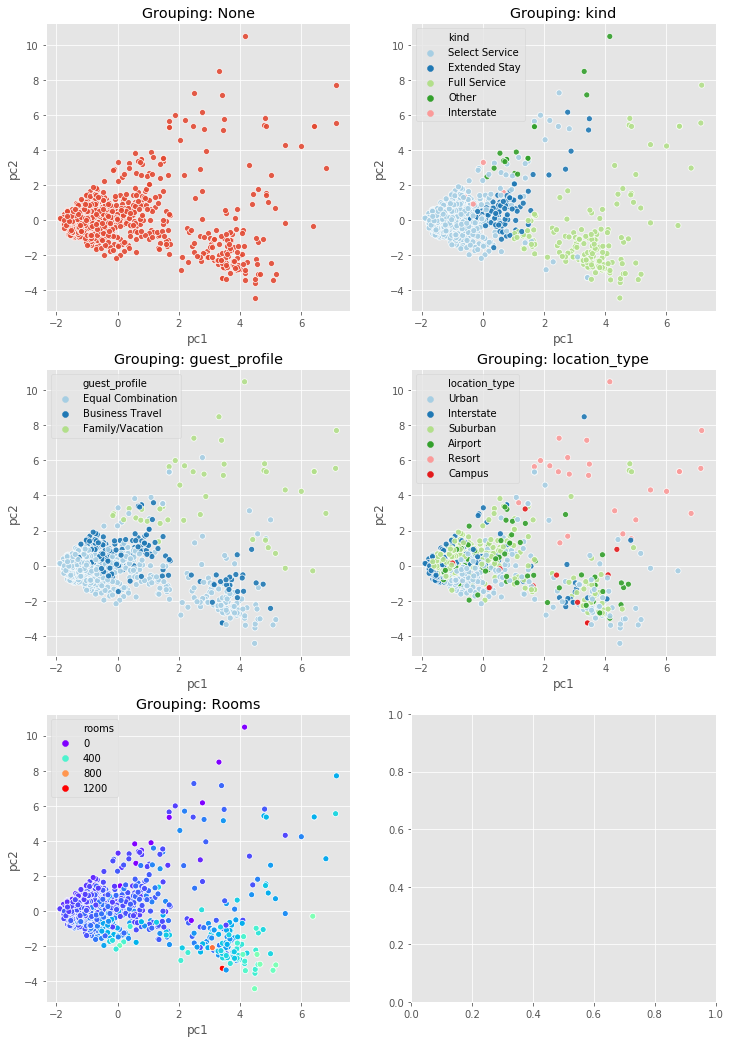

In [118]:
fig, ax = plt.subplots(3,2, figsize = (12,18))
pca_plot('pc1', 'pc2', props, axs = ax[0,0])
pca_plot('pc1', 'pc2', props, group = 'kind', axs = ax[0,1])
pca_plot('pc1', 'pc2', props, group = 'guest_profile', axs = ax[1,0])
pca_plot('pc1', 'pc2', props, group = 'location_type', axs = ax[1,1])
sns.scatterplot('pc1', 'pc2', data = props, hue = 'rooms',
                palette = 'rainbow', ax = ax[2,0]).set_title('Grouping: Rooms')
;

# Clustering

## K-Means

In [119]:
from sklearn.cluster import KMeans

In [120]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(props_mod)
clusters = kmeans.predict(props_mod)

In [121]:
props['kmeans'] = clusters.astype('object')

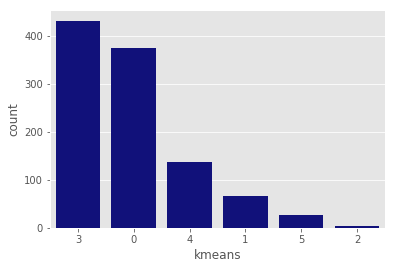

In [122]:
sns.countplot('kmeans', data = props, color = 'darkblue',
              order = props['kmeans'].value_counts().index)

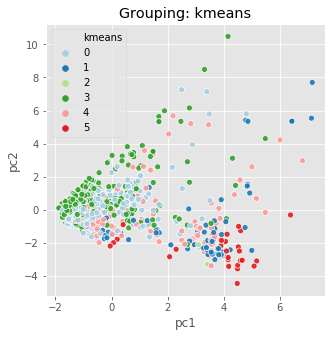

In [123]:
fig, ax = plt.subplots(figsize = (5,5))
pca_plot('pc1','pc2',props, 'kmeans')

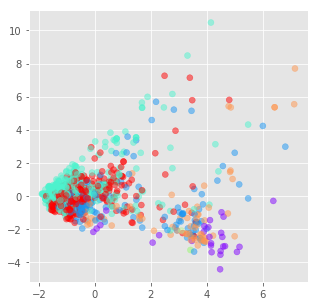

In [124]:
props_mod_pca['kmeans'] = clusters
fig, ax = plt.subplots(figsize = (5,5))

ax = plt.scatter(props_mod_pca.pc1,props_mod_pca.pc2,
                 c = props_mod_pca.kmeans, 
                 alpha = .5, 
                 cmap = 'rainbow_r', label = '1')

### What is the closest to the centroid of each cluster?

In [125]:
from sklearn.metrics import pairwise_distances_argmin_min

In [126]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, props_mod)
pd.concat([pd.DataFrame({'cluster': [i for i in range(6)]}), 
           props.iloc[closest].reset_index()], 
          axis = 1).drop('index', axis = 1)

,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans
0,0,SEABO,6747,"Hilton Garden Inn Seattle/Bothell, WA",22600 Bothell Everett Highway,Bothell,WA,9,10.4,10.4,10.4,25282,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,128,USD,4,-0.954321,-0.304798,0
1,1,JAXJA,6357,Embassy Suites Jacksonville Baymeadows,9300 Baymeadows Road,Jacksonville,FL,3,7.0,7.0,7.0,171,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,277,USD,10,-0.280518,-0.438859,1
2,2,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.0,0.0,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2
3,3,GEDIT,7111,Tru by Hilton Georgetown,301 College Park Lane,Georgetown,DE,1,0.0,0.0,0.0,6091,147,Tru by Hilton,1,Hilton,Select Service,Equal Combination,1,Campus,90,USD,5,-1.045545,-0.178902,3
4,4,ATLPH,7389,Hilton Garden Inn Atlanta Perimeter Center,1501 Lake Hearn Drive,Atlanta,GA,3,8.0,8.0,8.0,25121,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Interstate,193,USD,7,-0.882512,-0.257827,4
5,5,NYCWF,6081,Hilton Garden Inn New York Central Park South ...,237 West 54th Street,New York,NY,1,0.0,0.0,0.0,3311,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,401,USD,5,0.199098,-1.766981,5


In [127]:
props.iloc[closest]

,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans
433,SEABO,6747,"Hilton Garden Inn Seattle/Bothell, WA",22600 Bothell Everett Highway,Bothell,WA,9,10.4,10.4,10.4,25282,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,128,USD,4,-0.954321,-0.304798,0
228,JAXJA,6357,Embassy Suites Jacksonville Baymeadows,9300 Baymeadows Road,Jacksonville,FL,3,7.0,7.0,7.0,171,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,277,USD,10,-0.280518,-0.438859,1
533,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.0,0.0,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2
646,GEDIT,7111,Tru by Hilton Georgetown,301 College Park Lane,Georgetown,DE,1,0.0,0.0,0.0,6091,147,Tru by Hilton,1,Hilton,Select Service,Equal Combination,1,Campus,90,USD,5,-1.045545,-0.178902,3
552,ATLPH,7389,Hilton Garden Inn Atlanta Perimeter Center,1501 Lake Hearn Drive,Atlanta,GA,3,8.0,8.0,8.0,25121,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Interstate,193,USD,7,-0.882512,-0.257827,4
709,NYCWF,6081,Hilton Garden Inn New York Central Park South ...,237 West 54th Street,New York,NY,1,0.0,0.0,0.0,3311,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,401,USD,5,0.199098,-1.766981,5


### Determining K (Number of Clusters)

In [232]:
clusterings = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(props_mod)
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, props_mod)
    centroids = pd.concat([pd.DataFrame({'cluster': [i for i in range(k)]}), 
                           props.iloc[closest].reset_index()], 
                          axis = 1).drop('index', axis = 1)
    clusterings.append((k, kmeans.predict(props_mod), centroids))

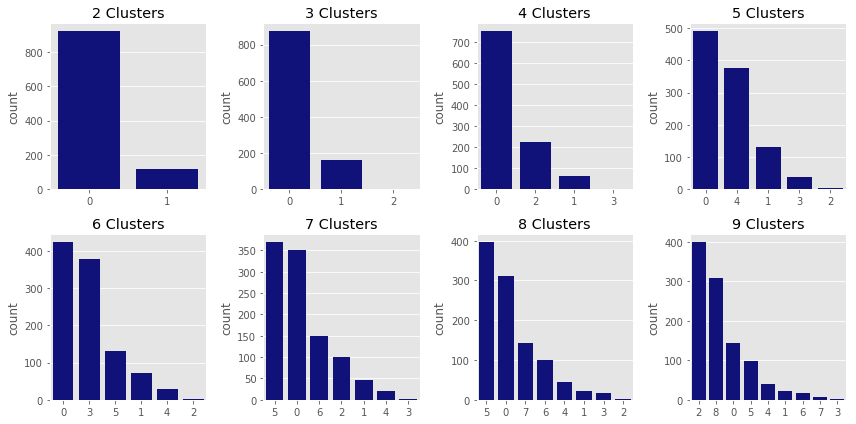

In [252]:
fig, axs = plt.subplots(2,4, figsize = (12, 6))

for clst, ax in zip(clusterings,axs.flatten()):
    sns.countplot(clst[1], color = 'darkblue', ax = ax,
              order = np.argsort(np.unique(clst[1], return_counts=True)[1])[::-1])
    ax.set_title(str(clst[0]) + ' Clusters')
    ax.set_xlabel = ('Cluster #')
plt.tight_layout()

In [262]:
for clst in clusterings:
    print('Clostest to Centroids for ' + str(clst[0]) + ' Clusters')
    display(clst[2])

Clostest to Centroids for 2 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,GVLGN,7536,Hilton Garden Inn Gainesville,1735 Browns Bridge Road,Gainesville,GA,3,0.0,0.0,0.0,25301,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,118,USD,6,-0.976515,0.140998,0,0,1
1,1,4392,6755,Sheraton Bay Point Resort,4114 Jan Cooley Drive,Panama City Beach,FL,3,7.0,0.0,0.0,1791,145,Sheraton,39,Starwood,Full Service,Family/Vacation,1,Resort,320,USD,3,7.123368,5.543574,1,5,1


Clostest to Centroids for 3 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,ALOCF,6800,Hilton Garden Inn Cedar Falls,7213 Nordic Drive,Cedar Falls,IA,5,7.0,7.0,0.0,17127,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,113,USD,5,-1.271896,-0.391304,0,1,1
1,1,JAXJA,6357,Embassy Suites Jacksonville Baymeadows,9300 Baymeadows Road,Jacksonville,FL,3,7.0,7.0,7.0,171,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,277,USD,10,-0.280518,-0.438859,1,3,1
2,2,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.0,0.0,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2,2,1


Clostest to Centroids for 4 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,BHMDW,7267,Hilton Garden Inn Downtown Birmingham,250 18th Street South,Birmingham,AL,3,10.00,13.0,0.0,25135,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,104,USD,7,-0.684039,-0.395728,3,1,1
1,1,INDDN,7214,Hilton Indianapolis Hotel & Suites,120 W. Market St.,Indianapolis,IN,4,7.00,0.0,0.0,9821,81,Hilton,1,Hilton,Full Service,Equal Combination,1,Urban,352,USD,10,3.469462,-2.718692,5,4,1
2,2,CHINL,6530,Hilton Garden Inn Chicago North Loop,66 East Wacker Place,Chicago,IL,6,10.25,0.0,0.0,5101,1,Hilton Garden Inn,1,Hilton,Extended Stay,Equal Combination,1,Urban,191,USD,5,0.358393,-1.566451,4,3,1
3,3,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.00,0.0,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2,2,1


Clostest to Centroids for 5 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,IHG - MTHLY,7307,Holiday Inn Express & Suites Charlotte Arpt-Be...,250 Beatty Drive,Belmont,NC,2,2.00,7.00,10.00,25152,128,Holiday Inn Express & Suites,21,IHG,Select Service,Equal Combination,1,Airport,92,USD,5,-1.241772,-0.026207,3,1,1
1,1,CVGBA,6694,Embassy Suites Blue Ash,4554 Lake Forest Drive,Blue Ash,OH,4,5.75,5.75,5.75,7791,125,Embassy Suites,1,Hilton,Full Service,Equal Combination,1,Interstate,234,USD,9,2.933961,-2.080487,4,3,1
2,2,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.00,0.00,0.00,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2,2,1
3,3,WASCC,6921,Embassy Suites by Hilton Washington DC Convent...,900 10th Street NW,Washington,DC,can,6.00,8.00,0.00,3411,125,Embassy Suites,1,Hilton,Select Service,Equal Combination,1,Urban,384,USD,15,2.067670,-2.823413,5,4,1
4,4,GPTAP,7123,Hilton Garden Inn Gulfport Airport,14108 Airport Rd,Gulfport,MS,3,7.00,0.00,0.00,1601,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Airport,137,USD,6,-0.779732,-0.083613,0,0,1


Clostest to Centroids for 6 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,GEDIT,7111,Tru by Hilton Georgetown,301 College Park Lane,Georgetown,DE,1,0.0,0.0,0.0,6091,147,Tru by Hilton,1,Hilton,Select Service,Equal Combination,1,Campus,90,USD,5,-1.045545,-0.178902,3,1,1
1,1,JAXJA,6357,Embassy Suites Jacksonville Baymeadows,9300 Baymeadows Road,Jacksonville,FL,3,7.0,7.0,7.0,171,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Suburban,277,USD,10,-0.280518,-0.438859,1,3,1
2,2,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.0,0.0,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2,2,1
3,3,RKHRH,7128,Hilton Garden Inn Rock Hill,650 Tinsley Way,Rock Hill,SC,2,8.0,10.0,0.0,25301,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Interstate,127,USD,6,-1.406191,-0.665404,0,0,1
4,4,NYCWF,6081,Hilton Garden Inn New York Central Park South ...,237 West 54th Street,New York,NY,1,0.0,0.0,0.0,3311,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,401,USD,5,0.199098,-1.766981,5,4,1
5,5,ATLPH,7389,Hilton Garden Inn Atlanta Perimeter Center,1501 Lake Hearn Drive,Atlanta,GA,3,8.0,8.0,8.0,25121,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Interstate,193,USD,7,-0.882512,-0.257827,4,3,1


Clostest to Centroids for 7 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,RAPRC,7069,Hampton Inn & Suites by Hilton Rapid City Rush...,825 Elgin St.,Rapid City,SD,5,6.5,6.50,0.0,17127,21,Hampton Inn and Suites,1,Hilton,Select Service,Equal Combination,1,Urban,120,USD,5,-0.767504,-0.331482,0,0,1
1,1,BOSSB,6855,DoubleTree Suites by Hilton Hotel Boston - Cam...,400 Soldiers Field Road,Boston,MA,can,7.0,6.25,0.0,3411,41,Doubletree by Hilton,1,Hilton,Full Service,Equal Combination,1,Urban,308,USD,15,4.226870,-2.405736,1,5,1
2,2,NYCAP,7297,Hampton Inn NY-JFK,144-10 135th Avenue,Jamaica,NY,1,0.0,0.00,0.0,25395,31,Hampton Inn,1,Hilton,Select Service,Equal Combination,1,Urban,216,USD,8,-0.348781,-0.335778,4,3,1
3,3,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.0,0.00,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2,2,1
4,4,IHG - CMHOC,7053,Crowne Plaza Columbus-Downtown,33 East Nationwide Blvd,Columbus,OH,4,7.5,0.00,0.0,25259,131,Crowne Plaza Hotels and Resorts,21,IHG,Full Service,Equal Combination,1,Urban,419,USD,1,4.175394,-3.404154,5,4,1
5,5,MWOMD,5881,"Hampton Inn Middletown, OH",2880 Towne Boulevard,Middletown,OH,4,0.0,6.00,6.0,9681,21,Hampton Inn and Suites,1,Hilton,Select Service,Business Travel,1,Urban,87,USD,7,-0.411599,0.443385,3,1,1
6,6,MAFDB,7373,Hilton Garden Inn Midland,1301 North Loop 250 West,Midland,TX,7,0.0,0.00,0.0,25483,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Interstate,157,USD,5,-1.385985,-0.490543,0,0,1


Clostest to Centroids for 8 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,JAXSB,7032,Hilton Garden Inn Jacksonville Downtown Southbank,1201 Kings Avenue,Jacksonville,FL,3,7.0,7.00,0.0,1601,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Interstate,123,USD,6,-1.173323,-0.004267,0,0,1
1,1,IHG - CMHOC,7053,Crowne Plaza Columbus-Downtown,33 East Nationwide Blvd,Columbus,OH,4,7.5,0.00,0.0,25259,131,Crowne Plaza Hotels and Resorts,21,IHG,Full Service,Equal Combination,1,Urban,419,USD,1,4.175394,-3.404154,5,4,1
2,2,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.0,0.00,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2,2,1
3,3,232323,7098,Test,321 test,Testville,CA,3,9.0,0.00,0.0,25158,1,Hilton Garden Inn,1,Hilton,Full Service,Business Travel,1,Campus,10,USD,2,1.676631,0.304034,3,1,1
4,4,BOSSB,6855,DoubleTree Suites by Hilton Hotel Boston - Cam...,400 Soldiers Field Road,Boston,MA,can,7.0,6.25,0.0,3411,41,Doubletree by Hilton,1,Hilton,Full Service,Equal Combination,1,Urban,308,USD,15,4.226870,-2.405736,1,5,1
5,5,IHG - MTHLY,7307,Holiday Inn Express & Suites Charlotte Arpt-Be...,250 Beatty Drive,Belmont,NC,2,2.0,7.00,10.0,25152,128,Holiday Inn Express & Suites,21,IHG,Select Service,Equal Combination,1,Airport,92,USD,5,-1.241772,-0.026207,3,1,1
6,6,NYCAP,7297,Hampton Inn NY-JFK,144-10 135th Avenue,Jamaica,NY,1,0.0,0.00,0.0,25395,31,Hampton Inn,1,Hilton,Select Service,Equal Combination,1,Urban,216,USD,8,-0.348781,-0.335778,4,3,1
7,7,LAXHO,6548,Hilton Garden Inn Los Angeles Hollywood,2005 N. Highland Avenue,Los Angeles,CA,9,9.0,0.00,0.0,61,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,160,USD,3,-0.525220,-1.002132,0,0,1


Clostest to Centroids for 9 Clusters


,cluster,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,0,LAXHO,6548,Hilton Garden Inn Los Angeles Hollywood,2005 N. Highland Avenue,Los Angeles,CA,9,9.000,0.000,0.0,61,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,160,USD,3,-0.525220,-1.002132,0,0,1
1,1,WASCC,6921,Embassy Suites by Hilton Washington DC Convent...,900 10th Street NW,Washington,DC,can,6.000,8.000,0.0,3411,125,Embassy Suites,1,Hilton,Select Service,Equal Combination,1,Urban,384,USD,15,2.067670,-2.823413,5,4,1
2,2,IHG - MTHLY,7307,Holiday Inn Express & Suites Charlotte Arpt-Be...,250 Beatty Drive,Belmont,NC,2,2.000,7.000,10.0,25152,128,Holiday Inn Express & Suites,21,IHG,Select Service,Equal Combination,1,Airport,92,USD,5,-1.241772,-0.026207,3,1,1
3,3,ZYLEA,7009,IHG Army Hotels Fort Lee Lodge,2301 Mohone Ave,Fort Lee,VA,2,0.000,0.000,0.0,25213,101,Holiday Inn Express,21,IHG,Select Service,Business Travel,1,Campus,1000,USD,1,3.419683,-3.270341,2,2,1
4,4,NYCTF,6977,Hilton Garden Inn New York/West 35th Street,63 West 35th Street,New York,NY,1,8.875,8.875,0.0,25121,1,Hilton Garden Inn,1,Hilton,Select Service,Family/Vacation,1,Urban,298,USD,7,1.337797,1.360207,1,5,1
5,5,NYCAP,7297,Hampton Inn NY-JFK,144-10 135th Avenue,Jamaica,NY,1,0.000,0.000,0.0,25395,31,Hampton Inn,1,Hilton,Select Service,Equal Combination,1,Urban,216,USD,8,-0.348781,-0.335778,4,3,1
6,6,232323,7098,Test,321 test,Testville,CA,3,9.000,0.000,0.0,25158,1,Hilton Garden Inn,1,Hilton,Full Service,Business Travel,1,Campus,10,USD,2,1.676631,0.304034,3,1,1
7,7,MSYHA,6934,InterContinental New Orleans,444 St Charles Ave,New Orleans,LA,7,9.450,0.000,0.0,2051,133,Intercontinental Hotels Group,21,IHG,Full Service,Equal Combination,1,Urban,484,USD,2,4.477625,-4.434904,5,4,1
8,8,JAXSB,7032,Hilton Garden Inn Jacksonville Downtown Southbank,1201 Kings Avenue,Jacksonville,FL,3,7.000,7.000,0.0,1601,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Interstate,123,USD,6,-1.173323,-0.004267,0,0,1


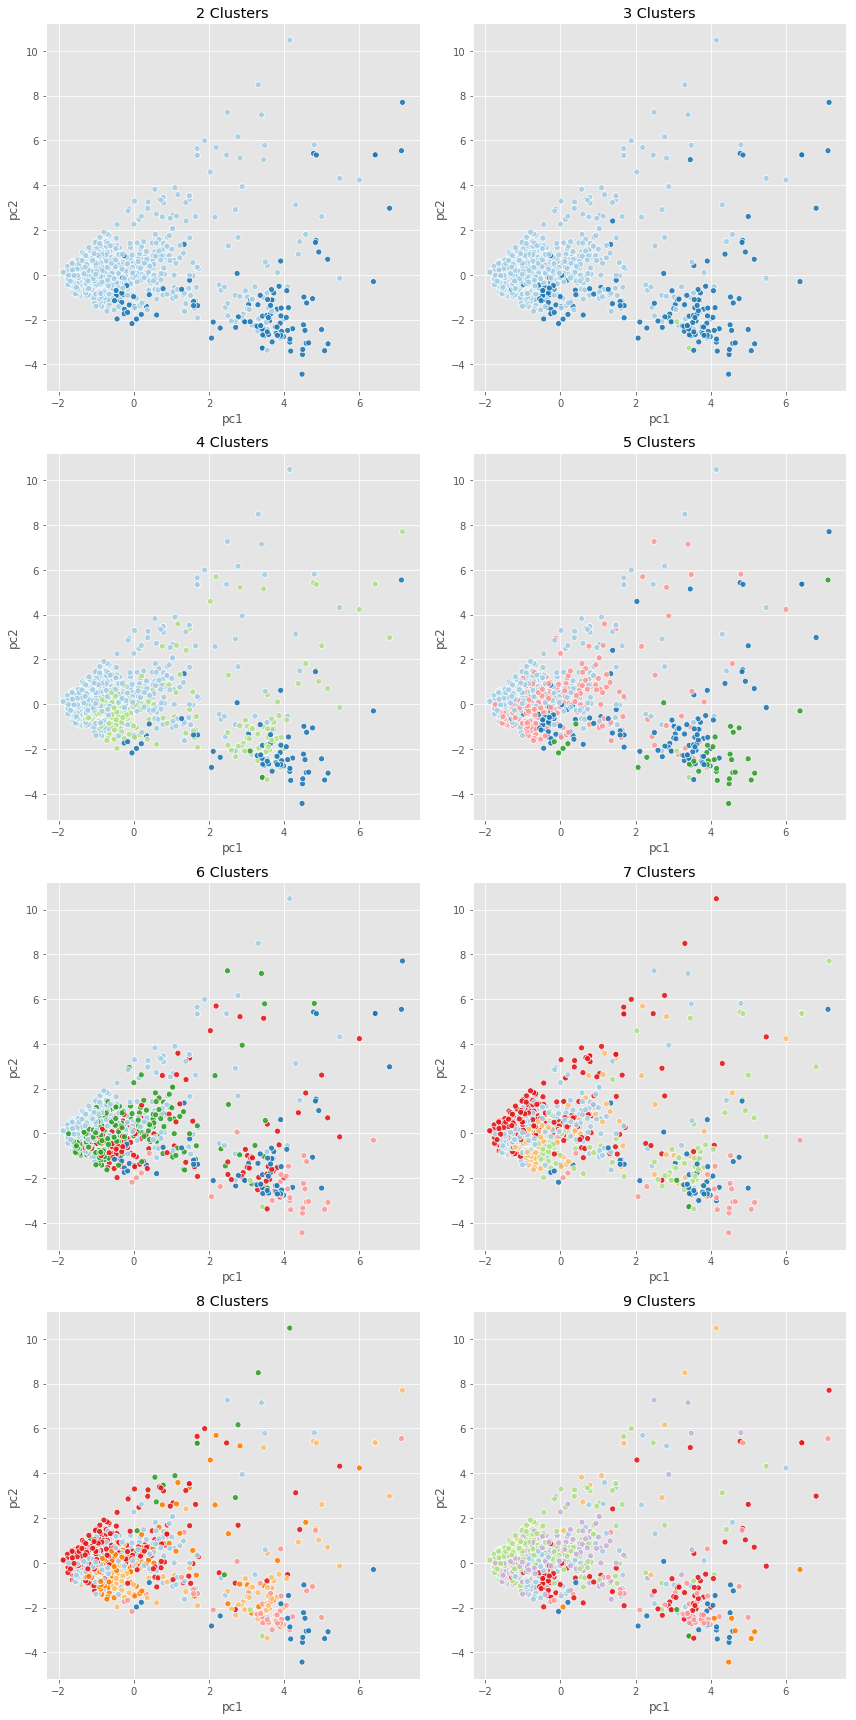

In [261]:
fig, axs = plt.subplots(4,2, figsize = (12, 24))

for clst, ax in zip(clusterings,axs.flatten()):
    df = props
    df['cluster'] = clst[1].reshape(-1,1)
    pca_plot('pc1','pc2',df, 'cluster', ax)
    ax.set_title(str(clst[0]) + ' Clusters')
    ax.get_legend().remove()

plt.tight_layout()

## Hierarchical 

In [128]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [129]:
Z1 = linkage(props_mod, 'ward')
Z2 = linkage(props_mod,"average", metric="cosine")

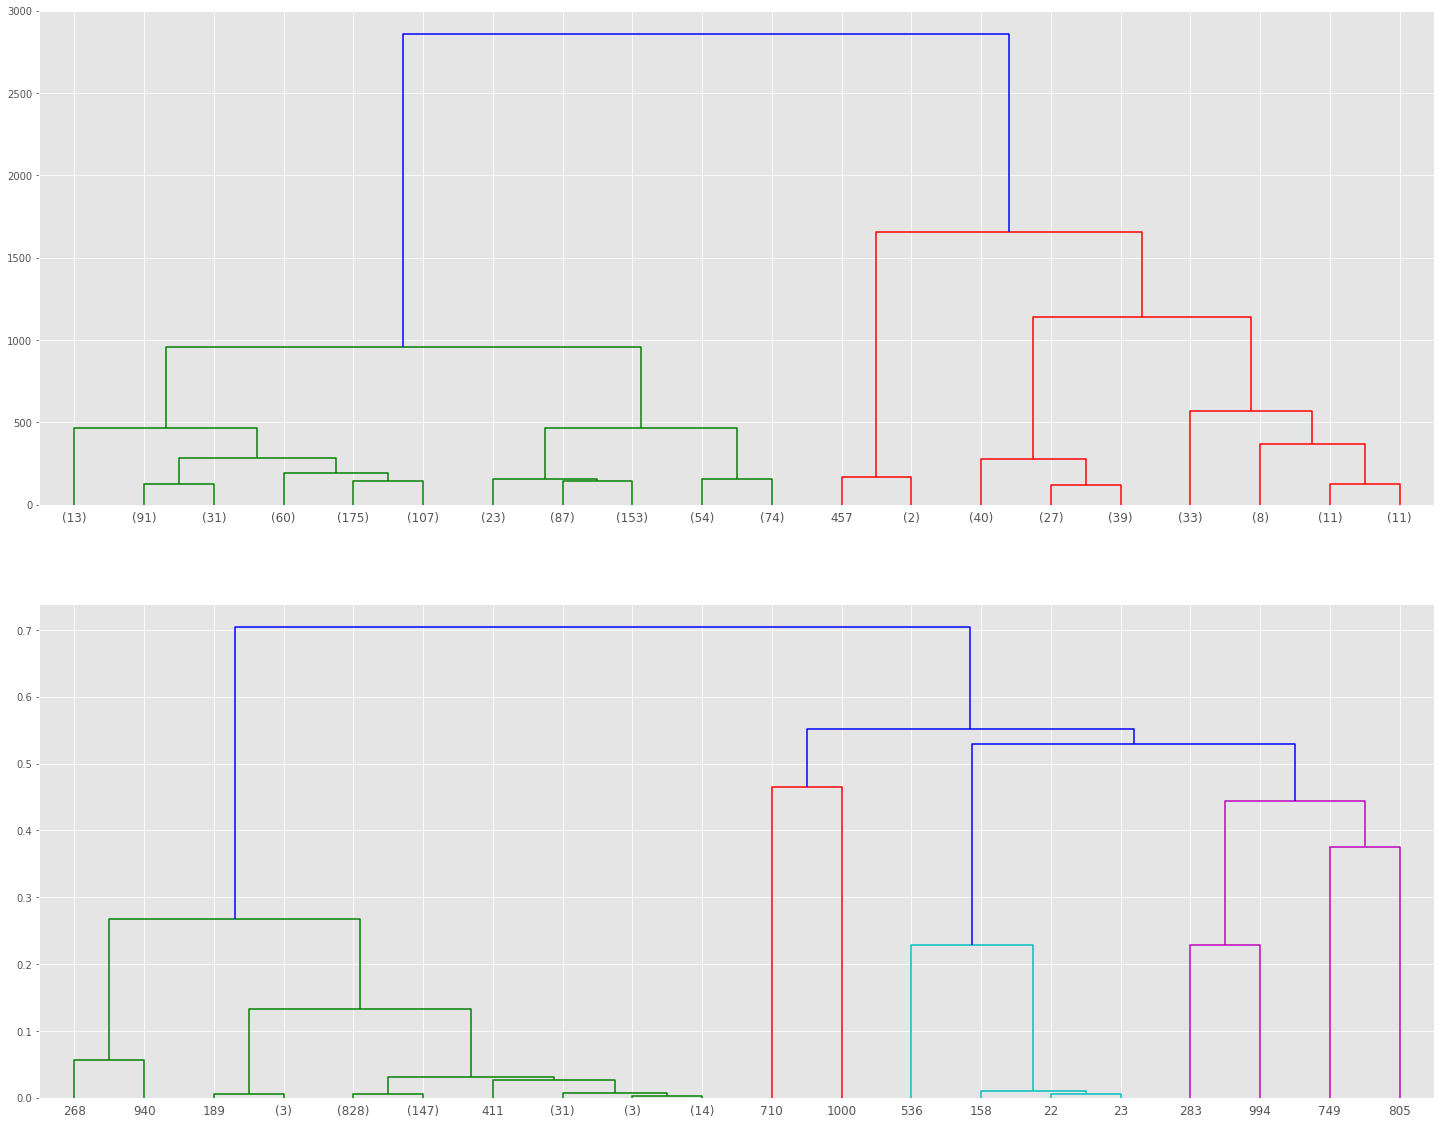

In [130]:
fig, ax = plt.subplots(2,1,figsize=(25, 20))
dn = dendrogram(Z1, truncate_mode='lastp', p = 20, ax = ax[0])
dn = dendrogram(Z2, truncate_mode='lastp', p = 20, ax = ax[1])

In [135]:
agg_ward_model = AgglomerativeClustering(n_clusters=6).fit(props_mod)
agg_ward = AgglomerativeClustering(n_clusters=6).fit_predict(props_mod)
agg_cos = AgglomerativeClustering(n_clusters=6,
                                  linkage = 'average',
                                  affinity = 'cosine').fit_predict(props_mod)

In [136]:
props['agg_ward'] = agg_ward
props['agg_cos'] = agg_cos

''

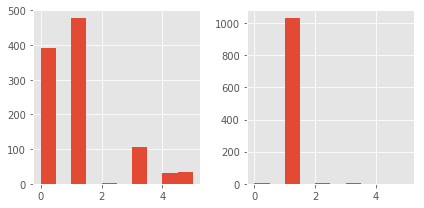

In [137]:
fig, ax = plt.subplots(1,2, figsize = (6,3))

ax[0].hist(agg_ward)
ax[1].hist(agg_cos)
plt.tight_layout()
;

''

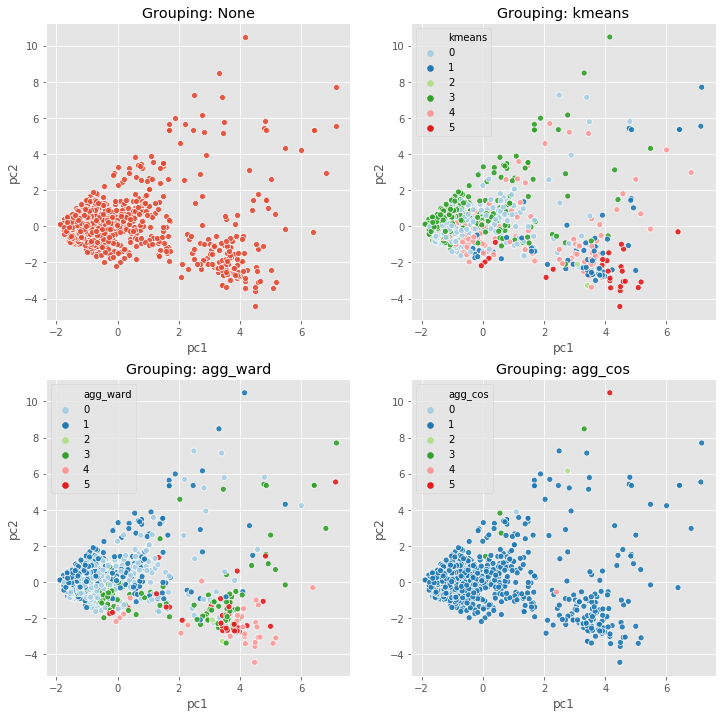

In [138]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
pca_plot('pc1', 'pc2', props, axs = ax[0,0])
pca_plot('pc1', 'pc2', props, group = 'kmeans', axs = ax[0,1])
pca_plot('pc1', 'pc2', props, group = 'agg_ward', axs = ax[1,0])
pca_plot('pc1', 'pc2', props, group = 'agg_cos', axs = ax[1,1])

;

In [139]:
from scipy.cluster.hierarchy import centroid
from scipy.spatial.distance import pdist

In [140]:
y = pdist(props_mod)
centroid(y).shape

(1039, 4)

## code from stack overflow to get to centroids

# Sum the vectors in each cluster
lens = {}      # will contain the lengths for each cluster
centroids = {} # will contain the centroids of each cluster
for idx,clno in enumerate(T):
    centroids.setdefault(clno,np.zeros(D)) 
    centroids[clno] += features[idx,:]
    lens.setdefault(clno,0)
    lens[clno] += 1
# Divide by number of observations in each cluster to get the centroid
for clno in centroids:
    centroids[clno] /= float(lens[clno])

# Writing table back to DB

In [142]:
from sqlalchemy import create_engine
import io
engine = create_engine('postgresql+psycopg2://postgres:@host:5435/impulsify')

In [143]:
props.head()

,property_code,property_id,property_name,address,city,state,zip,sales_tax_rate,alcohol_tax_rate,tobacco_tax_rate,management_company_id,flag_id,flag_name,brand_id,brand_name,kind,guest_profile,currency_id,location_type,rooms,currency,props_under_mgmt,pc1,pc2,kmeans,agg_ward,agg_cos
0,MOBDO,7530,Hilton Garden Inn Downtown Mobile,15 North Conception Street,Mobile,AL,3,0.00,0.0,0.0,25598,1,Hilton Garden Inn,1,Hilton,Select Service,Equal Combination,1,Urban,93,USD,1,-0.849534,-0.342654,3,1,1
1,DFWEU,7528,Tru by Hilton Euless DFW West,2570 State Highway 121,Euless,TX,7,0.00,0.0,0.0,10526,147,Tru by Hilton,1,Hilton,Select Service,Equal Combination,1,Interstate,79,USD,3,-1.853690,0.127906,3,1,1
2,DFWEL,7529,Home2 Suites by Hilton Euless DFW West,2570 State Highway 121,Euless,TX,7,0.00,0.0,0.0,10526,51,Home2,1,Hilton,Extended Stay,Equal Combination,1,Interstate,94,USD,3,-0.264996,0.202397,3,1,1
3,DALDR,6691,Hampton Inn & Suites Dallas Richardson,2250 N Glenville Dr.,Richardson,TX,7,8.25,0.0,0.0,10526,21,Hampton Inn and Suites,1,Hilton,Select Service,Business Travel,1,Suburban,101,USD,3,-0.859171,1.269357,3,1,1
4,CHIWX,7534,Hampton Inn Chicago West Loop,116 N Jefferson,Chicago,IL,6,0.00,0.0,0.0,3631,31,Hampton Inn,1,Hilton,Select Service,Equal Combination,1,Urban,210,USD,2,-0.528747,-0.861265,4,3,1


In [263]:
def push_table(df, table, db = 'impulsify', user = 'postgres',
               host= 'localhost', port = '5435'):
    '''
    inputs:
        df = dataframe to push
        table = table name to write in database
        db = database
        user, host, port = database connection info
    
    outputs:
        writres table to DB. Overwrites if table already exists
    '''
    engine = create_engine('postgresql+psycopg2://'+user+':@'+host+':'+port+'/'+db)
    props.head(0).to_sql(table, engine, if_exists='replace',index=False) #truncates the table
    
    conn = engine.raw_connection()
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep='\t', header=False, index=False)
    output.seek(0)
    contents = output.getvalue()
    cur.copy_from(output, table, null="") # null values become ''
    conn.commit()

In [264]:
push_table(props, 'property_clusters')